In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import os

In [ ]:

carpeta_co = "Datos_SIATA_Aire_co.json"

with open(carpeta_co, "r", encoding="utf-8") as f:data = json.load(f)

registros = []

        
for estacion in data:
    lat = estacion.get("latitud")
    lon = estacion.get("longitud")
    codigo = estacion.get("codigoSerial")
    nombre = estacion.get("nombre")
    nombreCorto = estacion.get("nombreCorto")
    datos = estacion.get("datos", [])

    for entrada in datos:
        registros.append({
            "codigoSerial": codigo,
            "nombreCorto": nombreCorto,
            "latitud": lat,
            "longitud": lon,
            "contaminante": entrada.get("variableConsulta"),
            "fecha": entrada.get("fecha"),
            "calibracion": entrada.get("valor"), # Ojooo esto es calibración 
            "valor": entrada.get("calidad") # Y esto calidad, osea que la calidad se llama valor y la calibración valga la redundancia calibración 
        })

# Convertimos a DataFrame como antes
df = pd.DataFrame(registros)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df["calibracion"] = pd.to_numeric(df["calibracion"], errors='coerce')


df.loc[df["calibracion"] == -9999, 'valor'] = np.nan

print(df.head(20))


    codigoSerial nombreCorto   latitud   longitud contaminante  \
0              3    GIR-SOSN  6.378433 -75.451141           co   
1              3    GIR-SOSN  6.378433 -75.451141           co   
2              3    GIR-SOSN  6.378433 -75.451141           co   
3              3    GIR-SOSN  6.378433 -75.451141           co   
4              3    GIR-SOSN  6.378433 -75.451141           co   
5              3    GIR-SOSN  6.378433 -75.451141           co   
6              3    GIR-SOSN  6.378433 -75.451141           co   
7              3    GIR-SOSN  6.378433 -75.451141           co   
8              3    GIR-SOSN  6.378433 -75.451141           co   
9              3    GIR-SOSN  6.378433 -75.451141           co   
10             3    GIR-SOSN  6.378433 -75.451141           co   
11             3    GIR-SOSN  6.378433 -75.451141           co   
12             3    GIR-SOSN  6.378433 -75.451141           co   
13             3    GIR-SOSN  6.378433 -75.451141           co   
14        

In [22]:
validos_por_estacion = df.groupby('nombreCorto')['valor'].apply(lambda x: x.notna().mean() * 100)
validos_por_contaminante = df.groupby('contaminante')['valor'].apply(lambda x: x.notna().mean() * 100)
print(f"Porcentaje datos válidos por estación\n{validos_por_estacion}\n\nPorcentaje datos válidos por contaminante{validos_por_contaminante}")

Porcentaje datos válidos por estación
nombreCorto
GIR-SOSN     0.000000
MED-PJIC    94.110261
SUR-TRAF     0.000000
Name: valor, dtype: float64

Porcentaje datos válidos por contaminantecontaminante
co    31.370087
Name: valor, dtype: float64


In [ ]:
# Obtener contaminante único (ya que el archivo es solo de uno)
contaminante_unico = df['contaminante'].unique()[0] if not df['contaminante'].isna().all() else "Desconocido"
#mostrar los datos validos de la estación med-pjic


,codigoSerial,nombreCorto,latitud,longitud,contaminante,fecha,calibracion,valor
0,3,GIR-SOSN,6.378433,-75.451141,co,2021-12-14 04:00:00,-9999.0,NaN
1,3,GIR-SOSN,6.378433,-75.451141,co,2021-12-14 05:00:00,-9999.0,NaN
2,3,GIR-SOSN,6.378433,-75.451141,co,2021-12-14 06:00:00,-9999.0,NaN
3,3,GIR-SOSN,6.378433,-75.451141,co,2021-12-14 07:00:00,-9999.0,NaN
4,3,GIR-SOSN,6.378433,-75.451141,co,2021-12-14 08:00:00,-9999.0,NaN
...,...,...,...,...,...,...,...,...
26278,48,SUR-TRAF,6.152313,-75.627487,co,2022-12-14 00:00:00,-9999.0,NaN
26279,48,SUR-TRAF,6.152313,-75.627487,co,2022-12-14 01:00:00,-9999.0,NaN
26280,48,SUR-TRAF,6.152313,-75.627487,co,2022-12-14 02:00:00,-9999.0,NaN
26281,48,SUR-TRAF,6.152313,-75.627487,co,2022-12-14 03:00:00,-9999.0,NaN


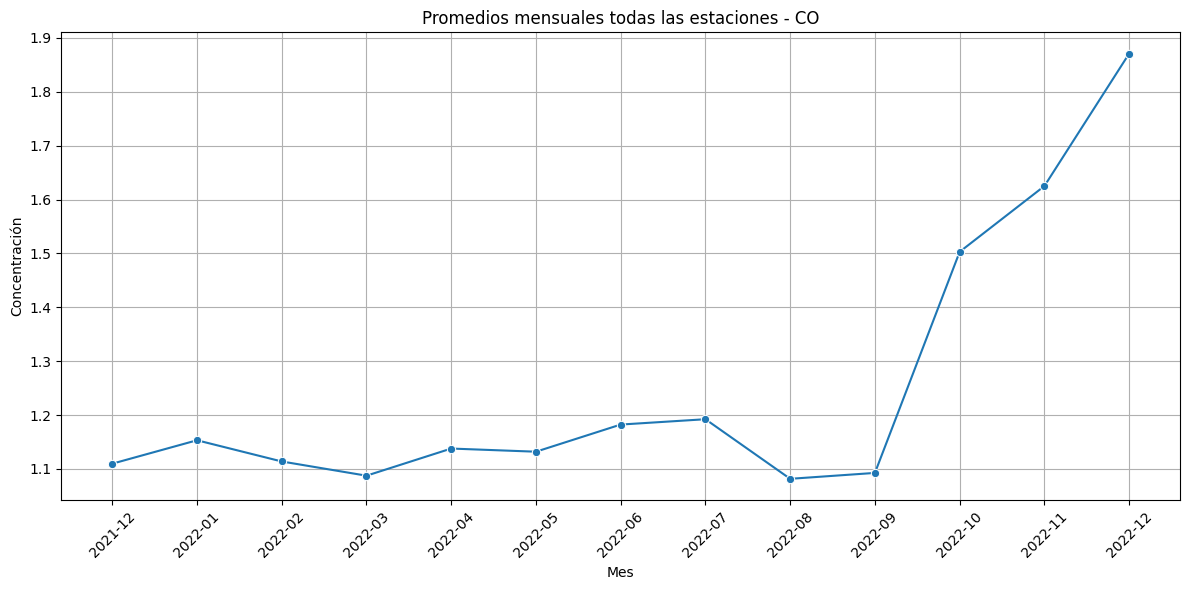

In [19]:
df['mes'] = df['fecha'].dt.to_period("M")
promedios_mensuales = df.groupby('mes')['valor'].mean().reset_index()
promedios_mensuales['mes'] = promedios_mensuales['mes'].astype(str)

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
plt.title(f'Promedios mensuales todas las estaciones - {contaminante_unico.upper()}')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 5. Mapa estático de estaciones



# Media por estacion
media_estaciones = df.groupby(['codigoSerial', 'latitud', 'longitud'])['valor'].mean().reset_index()

validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)

media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)


mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=6,
        popup=(
            f"Estación {row['codigoSerial']}\n"
            f"Media: {row['valor']:.2f}\n"
            f"Válidos: {row['porcentaje_validos']:.1f}%"
        ),
        color = 'green' if row['porcentaje_validos'] >= 51 else 'red',
        fill=True,
    ).add_to(mapa)

mapa

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().